# Crop Yield Prediction: XGBoost with Optuna Tuning

## Overview
This notebook trains a **Gradient Boosting Machine (XGBoost)** to predict crop yields. The target crop can be configured in the data loading section.

## Methodology
1.  **Crop Selection:** User selects the specific crop to predict from available data.
2.  **Feature Analysis:** Displaying used features.
3.  **Time-Series Split (Consistency Check):**
    * **Train (< 2016):** Model learning.
    * **Validation (2016 - 2020):** Hyperparameter tuning and early stopping.
    * **Test (>= 2020):** Final unseen evaluation.
4.  **Baseline:** Naive approach (Last Year's Yield).
5.  **Initial Model & Diagnostics:** Training a default XGBoost and plotting the **Learning Curve** to check for under/overfitting.
6.  **Optimization:** Using **Optuna** to find the best hyperparameters, visualized with parallel coordinates and importance plots.
7.  **Final Evaluation:** Comparing RMSE and R2 across all stages.

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Loading & Crop Selection

In [65]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4729


### 2. Feature Selection & Data Split
We display the features being used and split the data strictly by year to prevent leakage.

In [66]:
# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT match the chosen crop
# Example: If predicting Rice, we drop 'avg_yield_lettuce_1y', etc.
# --- keep list: cereals that must NOT be dropped ---
CEREALS_KEEP = ["barley", "wheat", "rice", "maize_corn"]

# overwrite logic
cols_to_drop = [
    c for c in df_model.columns
    if c.startswith("avg_yield_")
    and CHOSEN_CROP not in c
    and not any(c.startswith(f"avg_yield_{crop}") for crop in CEREALS_KEEP)
]

df_model = df_model.drop(columns=cols_to_drop)


# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['year', 'area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# 1. Training Set (< 2016)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2016 and < 2020)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2020)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})    : {len(X_train)}")
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")


Total Features Used: 31
------------------------------


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Feature Name,avg_yield_maize_corn_1y,avg_yield_maize_corn_3y,avg_yield_maize_corn_5y,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,avg_yield_wheat_1y,avg_yield_wheat_3y,avg_yield_wheat_5y,avg_yield_barley_1y,...,avg_solar_annual,avg_temp_winter,avg_temp_spring,avg_temp_summer,avg_temp_autumn,avg_temp_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude



Training Samples   (<2016)    : 3808
Validation Samples (2016-2020): 462
Testing Samples    (>=2020)    : 459


### 3. Baseline Model
Calculating performance if we simply predicted "Last Year's Yield".

In [67]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 525.00


### 4. Initial Model & Learning Curve Analysis
We train a model with default parameters and visualize the **Learning Curve** to ensure the model is converging and check for early signs of overfitting.

[0]	validation_0-rmse:3707.08023	validation_1-rmse:4409.52643
[100]	validation_0-rmse:312.24301	validation_1-rmse:491.16454
[155]	validation_0-rmse:277.88755	validation_1-rmse:494.91869


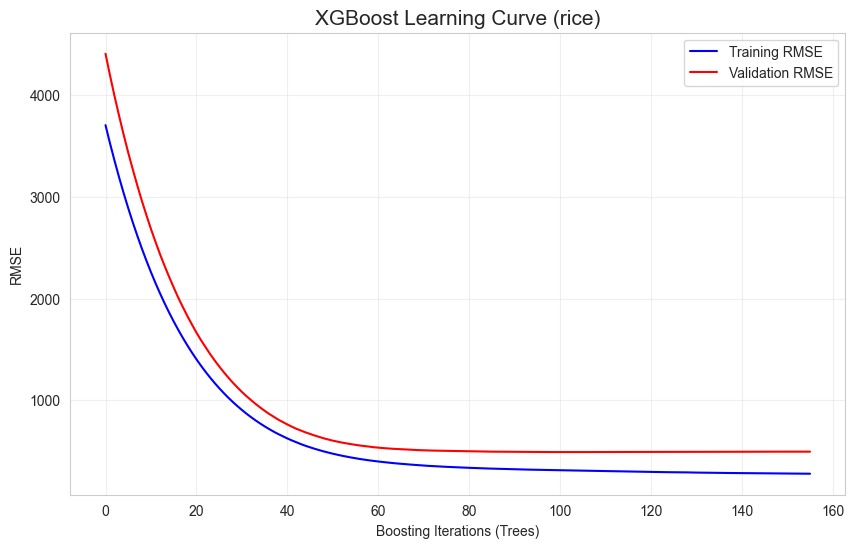

Initial Model Test RMSE: 558.15


In [68]:
# --- INITIAL MODEL TRAINING ---

# 1. Initialize XGBoost
model_init = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,        # Default comparable to LGBM's num_leaves ~32
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # Early stopping is often defined in constructor in newer XGB versions
)

# 2. Train on TRAIN, Early Stop on VALIDATION
# Note: XGBoost creates 'validation_0' and 'validation_1' by default if names aren't mapped
model_init.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=100
)

# 3. Retrieve evaluation results
results = model_init.evals_result()

# --- PLOT LEARNING CURVE (RMSE over Iterations) ---
def plot_learning_curve(results, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    # XGBoost stores results as 'validation_0', 'validation_1'
    train_metric = results['validation_0'][metric]
    val_metric = results['validation_1'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title(f'XGBoost Learning Curve ({CHOSEN_CROP})', fontsize=15)
    plt.xlabel('Boosting Iterations (Trees)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(results)

# Evaluate on TEST Set
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

print(f"Initial Model Test RMSE: {rmse_init_test:.2f}")

### 5. Optuna Hyperparameter Optimization
We optimize hyperparameters to minimize RMSE on the Validation set.

In [69]:
# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Roughly similar intent to min_child_samples
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 30
    }
    
    model = xgb.XGBRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Yield_XGBoost'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=30)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-27 18:28:00,855] A new study created in memory with name: Rice_Yield_XGBoost
[I 2025-11-27 18:28:02,404] Trial 0 finished with value: 476.7599423101116 and parameters: {'learning_rate': 0.010911090936956584, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.72432560693251, 'colsample_bytree': 0.6081430949124084, 'reg_alpha': 0.0018281050614337852, 'reg_lambda': 1.8314119974411192}. Best is trial 0 with value: 476.7599423101116.
[I 2025-11-27 18:28:02,756] Trial 1 finished with value: 490.77728873452526 and parameters: {'learning_rate': 0.08861786280060845, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6393559107287238, 'colsample_bytree': 0.5610455266708565, 'reg_alpha': 0.05539410363608731, 'reg_lambda': 0.15427155866774656}. Best is trial 0 with value: 476.7599423101116.
[I 2025-11-27 18:28:03,268] Trial 2 finished with value: 504.09376229672404 and parameters: {'learning_rate': 0.09186115014460922, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.6701264


Best Parameters found:
{'learning_rate': 0.07884790739638123, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7480215274488633, 'colsample_bytree': 0.7983869718757346, 'reg_alpha': 1.1803487382613221e-07, 'reg_lambda': 0.001204553984733492}


### 6. Optuna Visualization
Visualizing the tuning process to understand parameter importance and convergence.

In [70]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_Model"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Tuned Model Training
Retraining the model using the best parameters found on the full history (Train + Validation).

In [71]:
# 1. Combine Train + Validation for Final Training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# 2. Initialize with Best Params
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['early_stopping_rounds'] = 50

final_model = xgb.XGBRegressor(**best_params)

# 3. Train on Full History
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    verbose=50
)

# 4. Final Prediction on TEST Data
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

[0]	validation_0-rmse:3675.18444	validation_1-rmse:4410.81237
[50]	validation_0-rmse:444.10137	validation_1-rmse:482.82617
[100]	validation_0-rmse:410.05015	validation_1-rmse:475.72389
[128]	validation_0-rmse:394.44500	validation_1-rmse:479.74664


### 8. Final Results & Plots

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=525.00, R2=0.9449
Initial Model:  RMSE=558.15, R2=0.9377
Tuned Model:    RMSE=473.51, R2=0.9551 (RMSE Improved 9.81%)


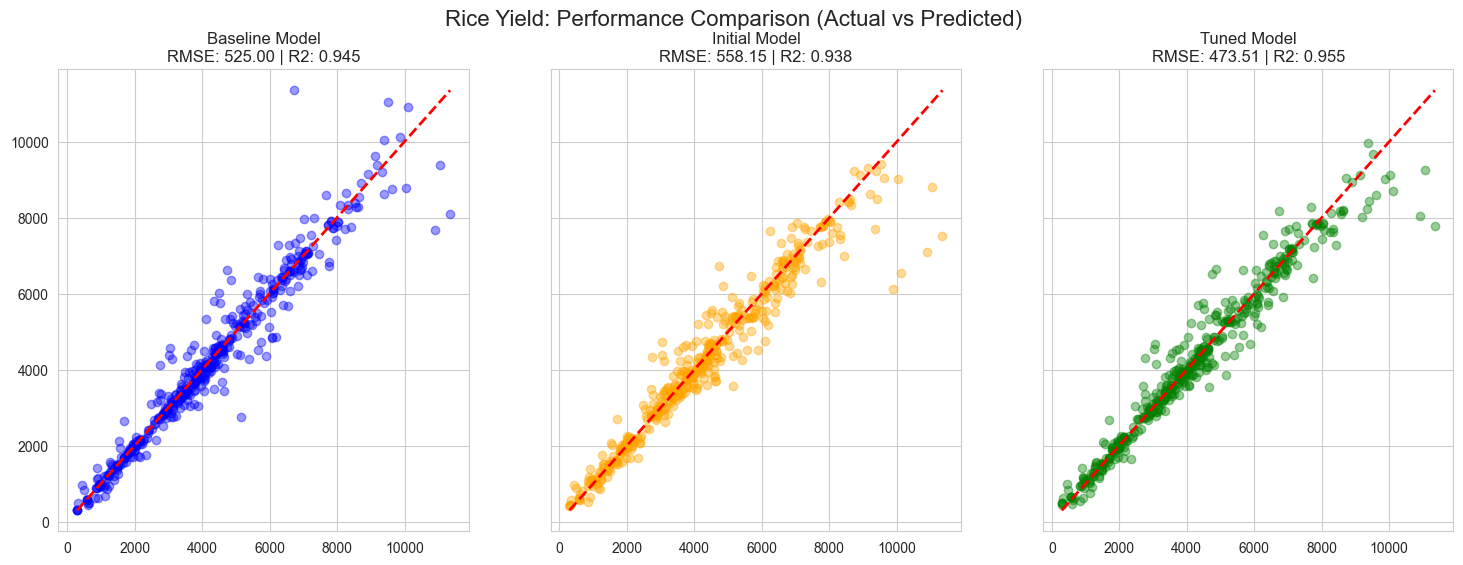

In [72]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:    RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.3f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial Model\nRMSE: {rmse_init_test:.2f} | R2: {r2_init_test:.3f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned Model\nRMSE: {rmse_final_test:.2f} | R2: {r2_final_test:.3f}')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Performance Comparison (Actual vs Predicted)', fontsize=16)
plt.show()


--- Top 20 Most Important Features (Text Report) ---
                    Feature  Importance (Gain)
0         avg_yield_rice_3y           0.408527
1         avg_yield_rice_1y           0.368645
2         avg_yield_rice_5y           0.042278
3   avg_yield_maize_corn_1y           0.015425
4          avg_solar_annual           0.012226
5          avg_solar_autumn           0.009385
6                 longitude           0.008405
7   avg_yield_maize_corn_3y           0.007631
8           fertilizer_lag1           0.007613
9        avg_yield_wheat_5y           0.007581
10          sum_rain_annual           0.006743
11      avg_yield_barley_1y           0.006304
12          avg_temp_spring           0.006283
13          avg_temp_winter           0.006247
14                 latitude           0.006030
15          sum_rain_autumn           0.005844
16      avg_yield_barley_3y           0.005796
17         avg_solar_spring           0.005735
18          avg_temp_autumn           0.005485
19  av

<Figure size 1200x800 with 0 Axes>

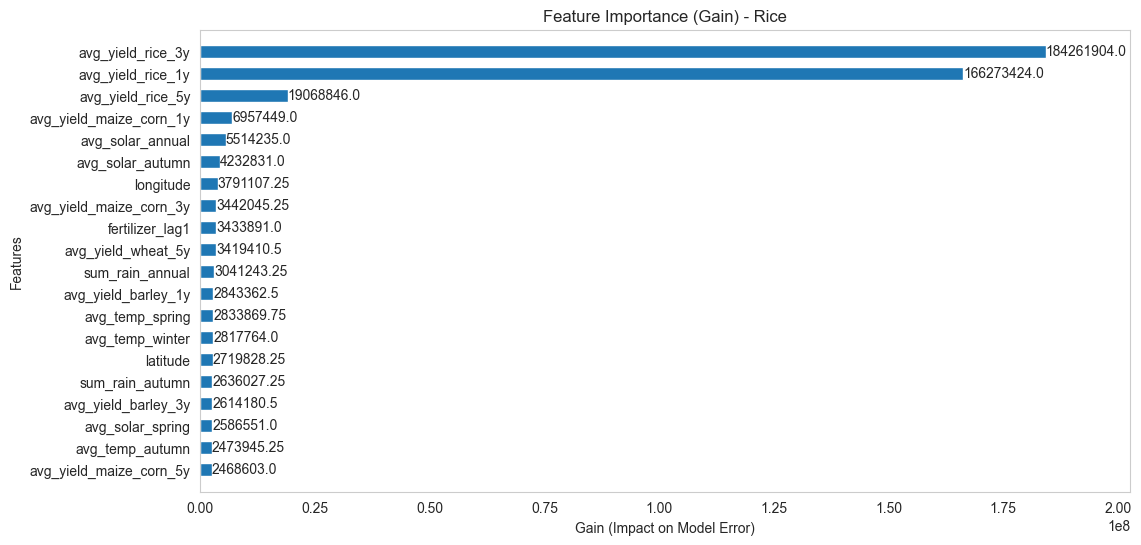

In [73]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances (using 'gain' type)
importances = final_model.feature_importances_
feature_names = final_model.feature_names_in_

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Gain)': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance (Gain)', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Use XGBoost's built-in plotter
plt.figure(figsize=(12, 8))
xgb.plot_importance(
    final_model, 
    max_num_features=20, 
    importance_type='gain', 
    title=f'Feature Importance (Gain) - {CHOSEN_CROP.capitalize()}',
    xlabel='Gain (Impact on Model Error)',
    height=0.6,
    grid=False
)
plt.show()

Generating maps for Target Year: 2023


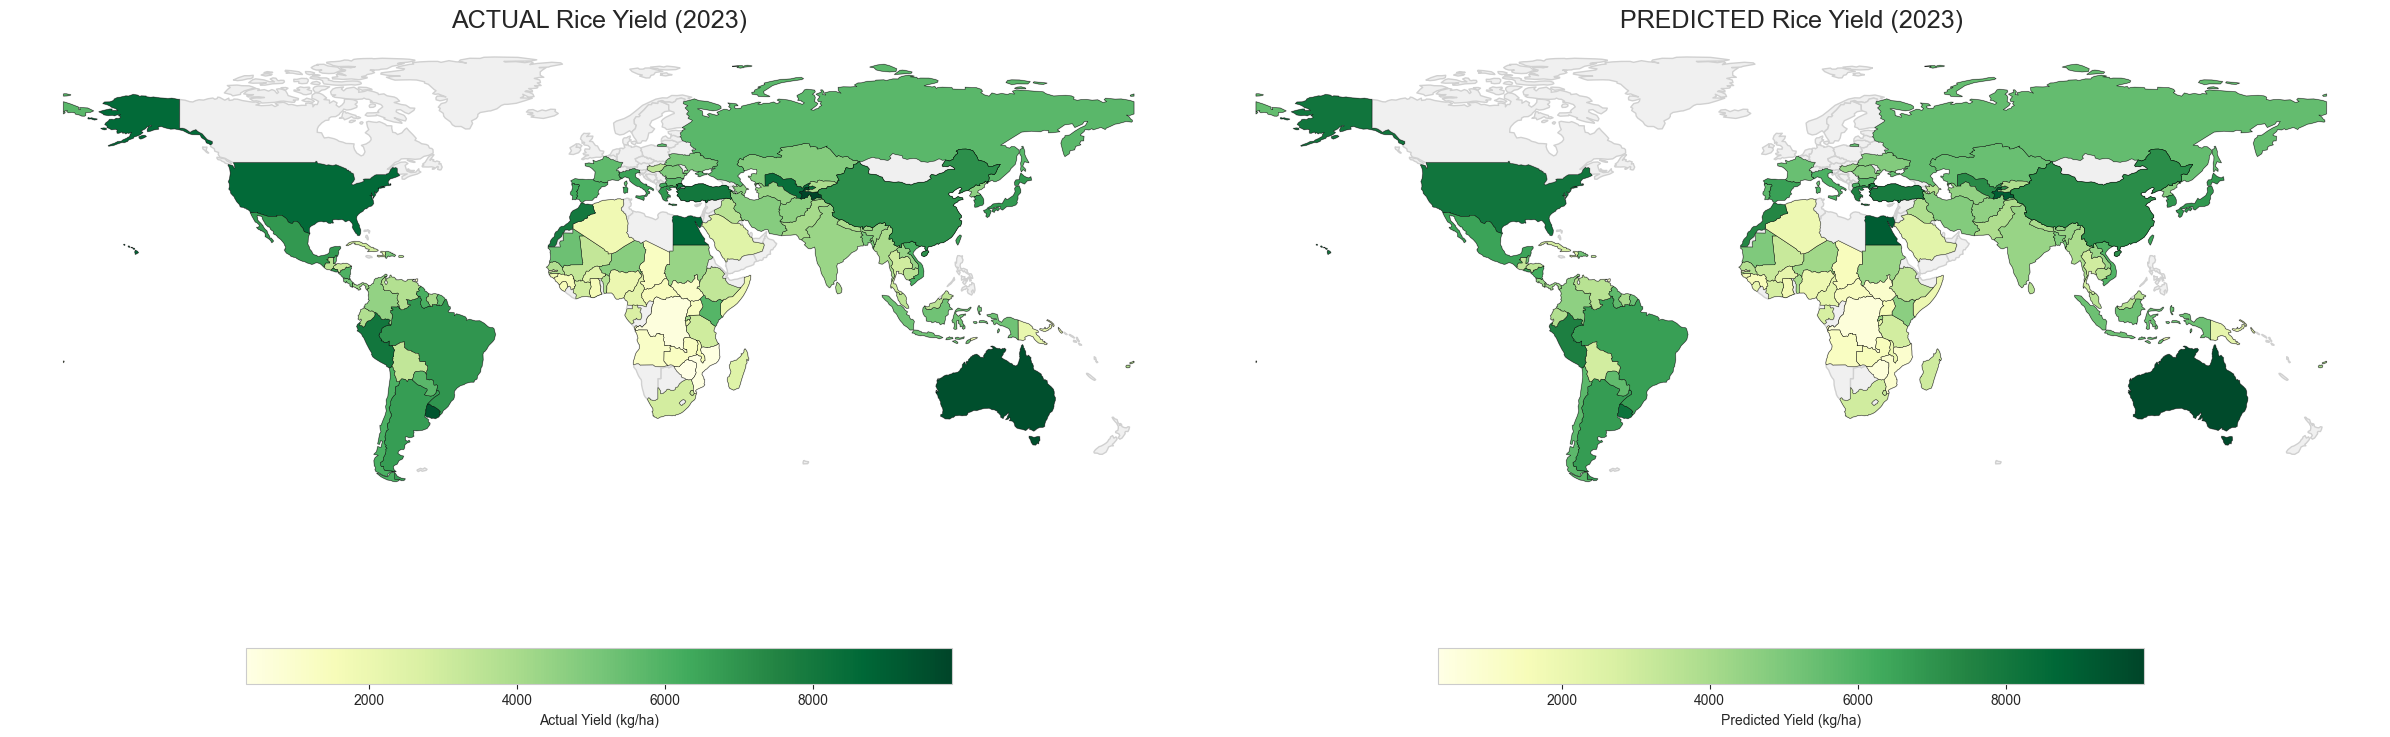

In [74]:
# cell_type: markdown
# ### 11. Spatial Analysis: Actual vs Predicted Maps
# Here we generate two side-by-side Choropleth maps. The target year is set as a parameter, allowing for easy adjustment.

# cell_type: code
import geopandas as gpd
import matplotlib.pyplot as plt

# --- 1. Set Target Year Parameter ---
# Change this value to map a different year (e.g., 2020, 2022)
target_year = 2023
print(f"Generating maps for Target Year: {target_year}")

# --- 2. Prepare Data ---
mask_target = df_model['year'] == target_year

if mask_target.sum() == 0:
    print(f"No data found for {target_year}. Please choose a different year.")
else:
    # Get Data and Make Predictions
    X_target = df_model[mask_target][feature_cols]
    actual_vals = df_model[mask_target][TARGET_COL].values
    pred_vals = final_model.predict(X_target)
    
    # Create a mapping DataFrame
    map_data = df_model[mask_target].copy()
    map_data['Predicted'] = pred_vals
    map_data['Actual'] = actual_vals
    
    # Rename target col for easier access
    map_data.rename(columns={'area': 'Area', 'latitude': 'lat', 'longitude': 'lon'}, inplace=True)

    # --- 3. Create GeoDataFrame & Load Map ---
    points_gdf = gpd.GeoDataFrame(
        map_data,
        geometry=gpd.points_from_xy(map_data.lon, map_data.lat),
        crs="EPSG:4326"
    )

    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
    except:
        print("Downloading map data...")
        world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
        name_col = 'NAME' if 'NAME' in world.columns else 'name'
        world = world[world[name_col] != 'Antarctica']

    # Join Data to Country Shapes
    world_data = gpd.sjoin(world, points_gdf, how="inner", predicate="intersects")

    # --- 4. Determine Shared Color Scale ---
    # Using the same scale (vmin, vmax) is crucial for visual comparison
    vmin = min(world_data['Actual'].min(), world_data['Predicted'].min())
    vmax = max(world_data['Actual'].max(), world_data['Predicted'].max())

    # --- 5. Plotting Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))

    # Map 1: Actual Yield
    world.plot(ax=axes[0], color='#f0f0f0', edgecolor='#d0d0d0')
    world_data.plot(
        column='Actual',
        ax=axes[0],
        legend=True,
        legend_kwds={'label': f"Actual Yield (kg/ha)", 'orientation': "horizontal", 'shrink': 0.6},
        cmap='YlGn',
        vmin=vmin, vmax=vmax,
        edgecolor='black', linewidth=0.3
    )
    axes[0].set_title(f'ACTUAL {CHOSEN_CROP.capitalize()} Yield ({target_year})', fontsize=18)
    axes[0].set_axis_off()

    # Map 2: Predicted Yield
    world.plot(ax=axes[1], color='#f0f0f0', edgecolor='#d0d0d0')
    world_data.plot(
        column='Predicted',
        ax=axes[1],
        legend=True,
        legend_kwds={'label': f"Predicted Yield (kg/ha)", 'orientation': "horizontal", 'shrink': 0.6},
        cmap='YlGn',
        vmin=vmin, vmax=vmax,
        edgecolor='black', linewidth=0.3
    )
    axes[1].set_title(f'PREDICTED {CHOSEN_CROP.capitalize()} Yield ({target_year})', fontsize=18)
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()